# Digit Recognizer

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/AnduScheusan/Documents/Contests/2024/Kaggle/Digit Recognizer/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/AnduScheusan/Documents/Contests/2024/Kaggle/Digit Recognizer/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/AnduScheusan/Documents/Contests/2024/Kaggle

In [2]:
train_df = pd.read_csv('../data/train.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [3]:
from sklearn.model_selection import train_test_split

features = train_df.drop('label', axis = 1)
labels = train_df['label']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.20, random_state = 42)

/Users/AnduScheusan/Documents/Contests/2024/Kaggle/Digit Recognizer/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [4]:
class ImagesTrainDataset(Dataset):
    def __init__(self, features, labels):
        super().__init__()
        self.features = torch.tensor(features, dtype=torch.float)
        self.labels = torch.tensor(labels, dtype=torch.int64)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

train_dataset = ImagesTrainDataset(X_train.values, y_train.values)

In [5]:
class ImagesValidationDataset(Dataset):
    def __init__(self, features, labels):
        super().__init__()
        self.features = torch.tensor(features, dtype=torch.float)
        self.labels = torch.tensor(labels, dtype=torch.int)
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        return self.features[index], self.labels[index]

validation_dataset = ImagesValidationDataset(X_test.values, y_test.values)

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32)

for X, y in train_dataloader:
    print(f"Shape of X: {X.shape} ({X.dtype})")
    print(f"Shape of Y: {y.shape} ({y.dtype})")
    break

for X, y in validation_dataloader:
    print(f"Shape of X: {X.shape} ({X.dtype})")
    print(f"Shape of Y: {y.shape} ({y.dtype})")
    break

Shape of X: torch.Size([32, 784]) (torch.float32)
Shape of Y: torch.Size([32]) (torch.int64)
Shape of X: torch.Size([32, 784]) (torch.float32)
Shape of Y: torch.Size([32]) (torch.int32)


In [7]:
device = (
    "cuda"
    if torch.cuda.is_available() else
    "mps"
    if torch.backends.mps.is_available() else
    "cpu"
)

device

'mps'

In [8]:
class DigitRecognizer(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        return self.stack(x)
    
model = DigitRecognizer().to(device)
print(model)

DigitRecognizer(
  (stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [10]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        pred = model(X)
        loss = loss_fn(pred, y)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"los:: {loss: > 7f} [{current:>5d}/{size:>5d}]")

In [11]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [12]:
epochs = 30

for t in range(epochs):
    print(f"Epoch {t + 1}\n------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(validation_dataloader, model, loss_fn)
    
print("Done!")

Epoch 1
------------------
los::  9.497040 [   32/33600]
los::  0.415026 [ 3232/33600]
los::  0.170325 [ 6432/33600]
los::  0.032881 [ 9632/33600]
los::  0.024339 [12832/33600]
los::  0.390196 [16032/33600]
los::  0.508847 [19232/33600]
los::  0.108753 [22432/33600]
los::  0.218741 [25632/33600]
los::  0.197224 [28832/33600]
los::  0.329404 [32032/33600]
Test Error: 
 Accuracy: 94.4%, Avg loss: 0.202606 

Epoch 2
------------------
los::  0.054228 [   32/33600]
los::  0.237972 [ 3232/33600]
los::  0.023153 [ 6432/33600]
los::  0.052180 [ 9632/33600]
los::  0.661162 [12832/33600]
los::  0.165387 [16032/33600]
los::  0.105305 [19232/33600]
los::  0.128014 [22432/33600]
los::  0.228585 [25632/33600]
los::  0.370423 [28832/33600]
los::  0.052437 [32032/33600]
Test Error: 
 Accuracy: 94.7%, Avg loss: 0.196316 

Epoch 3
------------------
los::  0.091406 [   32/33600]
los::  0.162238 [ 3232/33600]
los::  0.243108 [ 6432/33600]
los::  0.032537 [ 9632/33600]
los::  0.005769 [12832/33600]
los::

# Evaluation

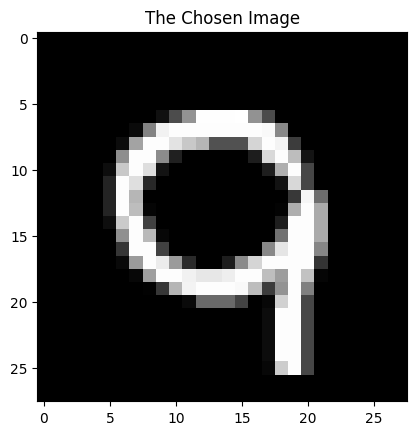

In [13]:
import matplotlib.pylab as plt

test_idx = 42
random_img = X_test.values[test_idx].reshape(28, 28)

plt.imshow(random_img, cmap='gray')
plt.title('The Chosen Image')
plt.show()

In [14]:
random_img_tensor = torch.tensor(X_test.values[test_idx], dtype=torch.float).to(device)
test_prediction = model(random_img_tensor)

prediction = test_prediction.argmax()

print(f"We got a prediction of {prediction}!")

We got a prediction of 9!


# Making a Submission

In [15]:
test_df = pd.read_csv('../data/test.csv')

In [16]:
results = []

with torch.no_grad():
    results = model(torch.tensor(test_df.values, dtype=torch.float).to(device))
    
results = results.argmax(dim=1)

In [147]:
submissions = pd.DataFrame({
    'ImageId': test_df.index + 1,
    'Label': results.cpu().numpy()
})

RuntimeError: Numpy is not available